# Assignment 2 - Data from the web

## Data scraping

## 1. Obtain all the data

In [625]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import os
import os.path
import re
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup

The first thing to do is to get the base URL (basically looking at the address bar of the browser).
We need a second variable INDEX_PARAM because this page is using frames, and we'll need the base address to access them.

In [155]:
BASE_URL = "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm"
INDEX_PARAM = "ww_i_reportmodel=133685247"

Then let's fetch the parameters names, but as it is a bit tricker, BeautifulSoup will be a great help for this (and also some manual html inspection).

In [156]:
r = requests.get(BASE_URL + '?' + INDEX_PARAM)
soup = BeautifulSoup(r.text, 'html.parser')


#print(soup)

for frame in soup.find_all('frame'):
    if frame['name'] == 'toc':
        r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/" + frame['src'])
        print(frame['src'])
# The content of the frame

# Print slects
soup = BeautifulSoup(r.text, 'html.parser')
query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'
    


!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247


For convenience, we also create another function that builds the query from some desired parameters.

In [157]:
def build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason):
    # Print slects
    soup = BeautifulSoup(r.text, 'html.parser')
    query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'


    for in_put in soup.findAll('input'):
        #print (in_put['name'])
        if in_put.text == "xls":
        #print(in_put['value'])
            query = query + '&' + in_put['name'] + '=' + in_put['value']
     
    for select in soup.findAll('select'):
    #print (select['name'])
        for t in select.findAll('option'):
        #print(t)
            if t.text == section:
            #print(t['value'])
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == str(startYear) + '-' + str(endYear):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == semesterType + " " + str(semesterNumber):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == "Semestre " + semesterSeason:
                query = query + '&' + select['name'] + '=' + t['value']
    return query


And finally a nice function to easily query the EPFL page and get the data from it.

In [354]:
DATA_FOLDER_PATH = 'Data/'
COLUMNS_NAMES = ["civility", "name", "bachelor_orientation", "master_orientation", "specialisation", "optional_spec", "minor", "status", "exchange_type", "exchange_school", "sciper"]
def query_epfl(section, startYear, endYear, semesterType, semesterNumber, semesterSeason, update = False, writeToFile = True):
    #we create files to save the queries (and network bandwidth)
    path = str(section) + str(startYear) + str(endYear) + str(semesterType) + str(semesterNumber) + str(semesterSeason)
    
    #to avoid file naming issues
    path = re.sub('[^A-Za-z0-9]+', '', path)
    path += ".xls"
    
    df = None
    #we query the epfl server only if the file does not exist, or if we want to update the data
    if(not os.path.isfile(DATA_FOLDER_PATH + path) or update):
        queryString = build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason)
        response = requests.get(queryString, stream=True)
        if response.status_code == 200:
            data = pd.read_html(response.text, match='.+', flavor=None, header=1, index_col=None, skiprows=1)
            df = data[0]
            df.drop(df.columns[[11, 12]], axis=1, inplace=True) #remove useless columns (all are empty)
            df.columns = COLUMNS_NAMES
            
            #cleaning the invalid rows (basically mapping the scipers to real numbers and remove the non-number rows)
            scipers = df['sciper']
            df = df.drop('sciper', axis=1)
            df = df.join(scipers.apply(pd.to_numeric, errors='coerce'))
            df = df[~df.sciper.isnull()]
            
            if writeToFile:
                df.to_excel(DATA_FOLDER_PATH + path) #save to xls file
    else:
        df = pd.read_excel(DATA_FOLDER_PATH + path, sheetname=0, header=0)
    
    return df

We can now start using those functions to collect data. 
Example below:

In [355]:
test = query_epfl("Informatique", 2007,2008, "Bachelor semestre", 3, "d'automne")
test.head()

,civility,name,bachelor_orientation,master_orientation,specialisation,optional_spec,minor,status,exchange_type,exchange_school,sciper
0,Monsieur,Aapro Niccolò,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170617.0
1,Monsieur,Arn Patrick,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174454.0
2,Monsieur,Balas Martin,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174774.0
3,Monsieur,Bandelier Matthieu,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,173962.0
4,Monsieur,Bindschaedler Laurent,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170654.0


We're now going to collect and merge every single semester of every single year. We'll append columns "year", "semester".

Together with a student's sciper, we'll use this to make unique indexes. We could've used the name but it's possible that two students with the same name would be in the same class in the same year and semestre.

In [516]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 7):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Bachelor semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

bStudents = pd.concat(frames)
bStudents.shape

(5807, 13)

We make sure the index is unique

In [872]:
bStudents.index.is_unique

True

In [886]:
bStudents.head()

civility                name  bachelor_orientation  \
semester year sciper                                                       
1        2007 169569  Monsieur   Arévalo Christian                   NaN   
              174905  Monsieur     Aubelle Flavien                   NaN   
              173922  Monsieur       Badoud Morgan                   NaN   
              179406  Monsieur  Baeriswyl Jonathan                   NaN   
              179428  Monsieur     Barroco Michael                   NaN   

                      master_orientation  specialisation optional_spec  minor  \
semester year sciper                                                            
1        2007 169569                 NaN             NaN           NaN    NaN   
              174905                 NaN             NaN           NaN    NaN   
              173922                 NaN             NaN           NaN    NaN   
              179406                 NaN             NaN           NaN    NaN   
              179428                 NaN             NaN           NaN    NaN   

                       status exchange_type exchange_school  sciper  year  \
semester year sciper                                                        
1        2007 169569  Présent           NaN             NaN  169569  2007   
              174905  Présent           NaN             NaN  174905  2007   
              173922  Présent           NaN             NaN  173922  2007   
              179406  Présent           NaN             NaN  179406  2007   
              179428  Présent           NaN             NaN  179428  2007   

                      semester  
semester year sciper            
1        2007 169569         1  
              174905         1  
              173922         1  
              179406         1  
              179428         1

With this very nice table, we still need the keep the students present in semester 1 and semester 6 only (and also filter out the columns we don't need).

In [898]:
bStudentsS1toS6 = pd.merge(bStudents.loc[1], bStudents.loc[6], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S6'))
bStudentsS1toS6 = bStudentsS1toS6[['civility', 'sciper', 'year_S1', 'year_S6']] #only retain the important fields

bStudentsS1toS6['year_S6'] += 1 #we do this because the last year is not the graduation year, but when it started (2015-2016 = 2015)
bStudentsS1toS6['ydiff'] = bStudentsS1toS6['year_S6'] - bStudentsS1toS6['year_S1']

bStudentsS1toS6 = bStudentsS1toS6.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.ydiff.idxmax()])
bStudentsS1toS6.set_index('sciper', inplace=True)
bStudentsS1toS6.head()

,civility,year_S1,year_S6,ydiff
sciper,,,,
147008,Monsieur,2008,2011,3
169569,Monsieur,2007,2010,3
169731,Monsieur,2007,2011,4
169795,Monsieur,2007,2011,4
171195,Monsieur,2007,2010,3


Quick check before proceeding

In [899]:
bStudentsS1toS6.index.is_unique

True

Before going further, we will modify the dataframe a bit to simplify the processing of genders

In [900]:
gender_map = {"Monsieur": 0, "Madame": 1}
bStudentsS1toS6['civility'] = bStudentsS1toS6['civility'].map(gender_map)

As a first approach, we use the 'describe' methods of pandas on the ydiff field

In [901]:
bStudentsS1toS6['ydiff'].describe()

count    397.000000
mean       3.468514
std        0.733155
min        3.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: ydiff, dtype: float64

Ignoring the count (which is meaningless in this case) and the min (since you can't get the bachelor in less than 3 years), we observe quite a low mean and std, but these should not be over considered since they are weak against outliers. 
But the quantiles give us nice informations, more than 50% of students graduated in 3 years (which is the minimum) and 75% in 4 years!
Then the maximum is 7, that is uncommon since you have 6 years to graduate.
Let's find out how many people are in this case

In [902]:
bStudentsS1toS6[bStudentsS1toS6.ydiff == 7]

,civility,year_S1,year_S6,ydiff
sciper,,,,
196034,0,2009,2016,7


As only one person is concerned, we can then assume that this dude had some special treatment.

Now that we are certain that our dataset is well formed, we can start to analyze it properly.
We begin by grouping the students by their graduation time.

ydiff
3    259
4     98
5     33
6      6
7      1
dtype: int64

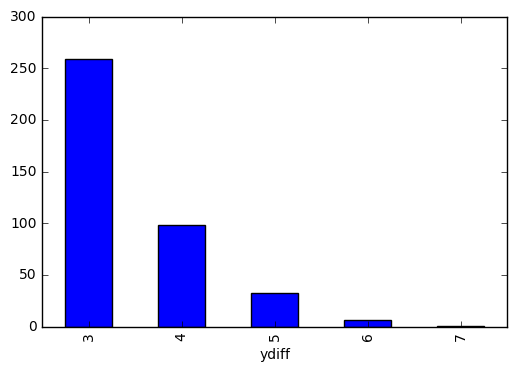

In [903]:
bStudentsS1toS6_grp = bStudentsS1toS6.groupby(bStudentsS1toS6.ydiff)
bStudentsS1toS6_grp.size().plot.bar()
bStudentsS1toS6_grp.size()

We don't see many more things than what the 'described()' function showed, only the large amount of people having graduated in the minimal time.

The next step is to split the students by their gender.

In [905]:
bStudentsByGender = bStudentsS1toS6.groupby(bStudentsS1toS6.civility)
bStudentsByGender.describe()

ydiff      year_S1      year_S6
civility                                            
0        count  368.000000   368.000000   368.000000
         mean     3.480978  2010.475543  2013.956522
         std      0.745316     2.029604     2.017164
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.750000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      7.000000  2014.000000  2017.000000
1        count   29.000000    29.000000    29.000000
         mean     3.310345  2010.620690  2013.931034
         std      0.541390     2.060059     2.170106
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.000000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      5.000000  2014.000000  2017.000000

Nothing significant to report here, only that most of the graduated students are men (368 against 29).

Mean:
civility
0    3.480978
1    3.310345
Name: ydiff, dtype: float64
STD:
civility
0    0.745316
1    0.541390
Name: ydiff, dtype: float64


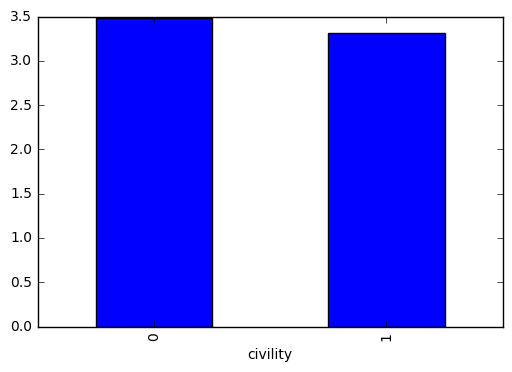

In [906]:
bStudentsByGender['ydiff'].mean().plot.bar()
print("Mean:\n" + str(bStudentsByGender['ydiff'].mean()))
print("STD:\n" + str(bStudentsByGender['ydiff'].std()))

There is no significant difference here, only that female students are a bit better and more uniformly distributed, but the size of the sample is too low to establish conclusions.